In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import lightgbm as lgbm
def set_seed(seed):
    np.random.seed(seed)
SEED = 3407
set_seed(SEED)

d:\LenovoSoftstore\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def lag_diff(grid_df,lag_cols,shift):
    for col in lag_cols:
        for i in range(shift, 4*shift, shift):
            grid_df[f'{col}_lag_{i}'] = grid_df[col].transform(lambda x:x.shift(i))
            grid_df[f'{col}_lag_{i}_diff'] = grid_df[col].transform(lambda x:x.shift(i).diff(i))
    
    return grid_df

In [3]:
data = pd.read_excel('daily.xlsx',index_col=0)

data[['covid','operation']] = data[['covid','operation']].fillna(0)
data[['CNY/SDR','opec']] = data[['CNY/SDR','opec']].fillna(method='pad').fillna(method='bfill')
data['interest_diff'] = data['bond_cn'] - data['bond_us']
lab = ['CNY/USD']
fea = [c for c in data.columns if (c not in lab)  & (c not in ['bond_us','bond_cn','agri_price'])]
data = lag_diff(data,fea,1)
fea = [c for c in data.columns if (c not in lab)  & (c not in ['bond_us','bond_cn','agri_price'])]
data = data[data['CNY/USD'].notna()]

In [4]:
def acc(y_true, y_pred):
    inds = np.where(y_true>0)
    y_true = y_true[inds]
    y_pred = y_pred[inds]
    score = np.sum((1 - np.abs(y_true-y_pred)/y_true)*y_true/np.sum(y_true))
    return score   

In [12]:
from sklearn.model_selection import KFold, TimeSeriesSplit

lgb_params = {
      "objective": "mae", #tweedie
      "metric": "mae", 
      "boosting_type": "goss",
        "num_leaves":2**6-1,
    "min_data_in_leaf":2**5,
      'early_stopping_rounds': 100,
      'learning_rate': 0.01,  
        'subsample': 0.8,
      'colsample_bytree':0.8, 
    "verbose":-1,
    'device' : 'gpu',
    "seed":SEED,
    'max_depth':3

}
X_tr_val = data.copy()
#X_te     = df_valid[fea]

# 待遍历的日期
dates = data.index.unique()
fold_nums = 4
kf = KFold(n_splits=fold_nums)
tskf = TimeSeriesSplit(n_splits=fold_nums, test_size=10)
lgb_models = []
importance = 0
y_pred = 0
pred_valid = 0
valid_accs = []
train_accs = []

In [13]:
for f,(tr_dt_ind,val_dt_ind) in enumerate(tskf.split(dates)): #kf.split(X_tr_val)
    #print(f"---------- {f} fold ----------")
    tr_dts, val_dts = dates[tr_dt_ind], dates[val_dt_ind]
    print("validation date: ", val_dts)
    tr_ind, val_ind = X_tr_val.index.isin(tr_dts), X_tr_val.index.isin(val_dts)
    X_train, X_valid = X_tr_val[tr_ind][fea], X_tr_val[val_ind][fea]
    y_train, y_valid = X_tr_val[tr_ind][lab], X_tr_val[val_ind][lab]
    
    lgbm_train = lgbm.Dataset(X_train,y_train)  
    lgbm_valid = lgbm.Dataset(X_valid,y_valid)

    model_mae = lgbm.train(params=lgb_params, 
                  train_set=lgbm_train,
                  valid_sets=[lgbm_train, lgbm_valid],
                  num_boost_round=16000, 
                    
                 callbacks=[lgbm.early_stopping(100), lgbm.log_evaluation(100)]
                          )
#                   categorical_feature = cate_features)
    #y_pred += model_mae.predict(X_te) / fold_nums
    #lgbm.plot_metric(booster = lgb_params)
    pred_valid = model_mae.predict(X_valid)
    pred_train = model_mae.predict(X_train)
    valid_acc = acc(y_valid.values, pred_valid.reshape([len(pred_valid),1]))
    valid_accs.append(valid_acc)
    train_acc = acc(y_train.values, pred_train.reshape([len(pred_train),1]))
    train_accs.append(train_acc)
    print(f"{f} fold valid acc {valid_acc}")
    print(f"{f} fold train acc {train_acc}")
    lgb_models.append(model_mae) 
    importance += model_mae.feature_importance(importance_type='gain') / fold_nums

print(f"--------- mean train acc {np.mean(train_accs)} ------------")
print(f"--------- mean valid acc {np.mean(valid_accs)} ------------")


validation date:  DatetimeIndex(['2022-08-05', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12', '2022-08-15', '2022-08-16',
               '2022-08-17', '2022-08-18'],
              dtype='datetime64[ns]', name='date', freq=None)
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.0888015	valid_1's l1: 0.035545
[200]	training's l1: 0.0388741	valid_1's l1: 0.0321672
[300]	training's l1: 0.0234961	valid_1's l1: 0.0306399
[400]	training's l1: 0.0183861	valid_1's l1: 0.0288641
[500]	training's l1: 0.0163248	valid_1's l1: 0.0296739
0 fold valid acc 0.9957656301314136
0 fold train acc 0.9974132553214817
validation date:  DatetimeIndex(['2022-08-19', '2022-08-22', '2022-08-23', '2022-08-24',
               '2022-08-25', '2022-08-26', '2022-08-29', '2022-08-30',
               '2022-08-31', '2022-09-01'],
              dtype='datetime64[ns]', name='date', freq=None)
Training until validation scores don't improve for 100 round

In [55]:
feats_importance = pd.DataFrame()
feats_importance['name'] = fea
feats_importance['importance'] = importance
feats_importance.sort_values(by='importance',inplace=True,ascending=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

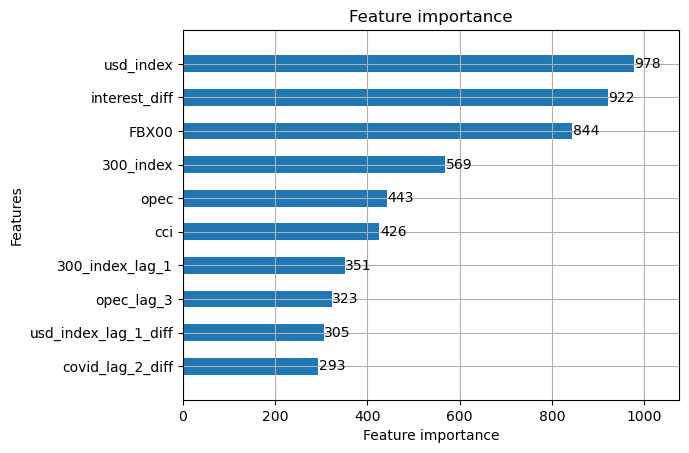

In [56]:
lgbm.plot_importance(booster= model_mae,height= 0.5,max_num_features= 10)

<AxesSubplot:>

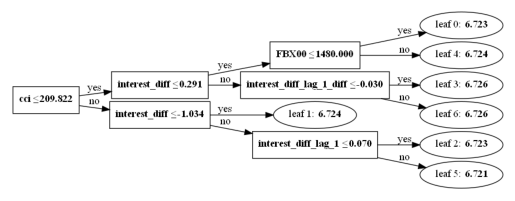

In [57]:
lgbm.plot_tree(booster=model_mae)

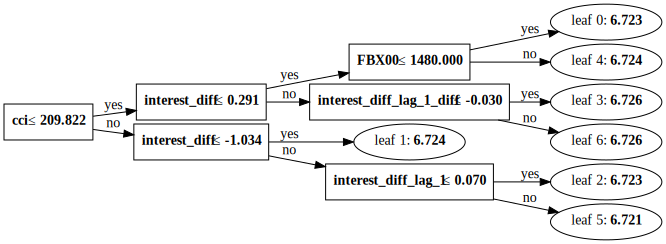

In [58]:
lgbm.create_tree_digraph(booster = model_mae)

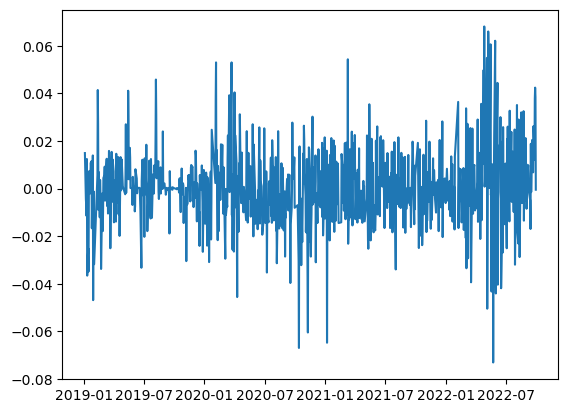

In [59]:
plt.plot(data.index,data['CNY/USD'].transform(lambda x:x.shift(1).diff(1)))
plt.show()